In [1]:
import cv2
import os
import numpy as np
import pytesseract

from predict_helpers import *


In [2]:
def unsharp_mask(image, sigma=1.0, strength=1.5, kernel_size=(5, 5)):
    # Apply Gaussian blur with specified kernel size
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    # Subtract the blurred image from the original
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened


def unsharp_mask_X(image, sigma=1.0, strength=1.5):
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Subtract the blurred image from the original
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

In [3]:

def annotate_meter(image_path):

    image = cv2.imread(image_path)
    # plot_image(image,"Original Images")

    # 2. Straighten
    #       Attemt to rotate the image so that the horizontal lines are straight,
    rotation_angle = determine_rotation_angle(image, horizontal_threshold=0.1)          
    image = rotate_image(image, rotation_angle)
    plot_image(image, f"Image rotated by {rotation_angle:.3f} degrees")

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    plot_image(gray,"Grayscale Image")

    # Apply unsharp masking with adjusted parameters
    #gray = unsharp_mask(gray, sigma=10.0, strength=10.0)
    #plot_image(gray,"Sharpened Images")


    # Find edges using "threshold"
    _, thresh =  cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    #_, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY) 
    plot_image(thresh, "Edged after cv2.threshold")

    # Find Canny edges 
    edged = cv2.Canny(gray, 30, 200) 
    plot_image(edged, "Edged after cv2.Canny")

    # Finding Contours 
    # Use a copy of the image e.g. edged.copy() 
    # since findContours alters the image 
    # cv.RETR_TREE
    # cv2.RETR_EXTERNAL
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    image_countours = cv2.drawContours(image, contours, -1, (0,255,75), 2)
    plot_image(image_countours, "Detected Countours")
    img_size_h, img_size_w = image.shape[:2]

    annotation = []
    digit_image_size = 180
    for pos, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        if (h < w) or (h > int(np.ceil(img_size_h * 0.8))) or (w > int(np.ceil(img_size_w * 0.8))):
            # Unrealistic size of box
            print(f"Unrealistic size of box {pos}: {image_path} Contour: x={x}, y={y}, h:{h}, w={w}, Area= {cv2.contourArea(contour)}")
            continue
        if cv2.contourArea(contour) > 200:
            print(f"Realistic size of box {pos}: {image_path} Contour: x={x}, y={y}, h:{h}, w={w}, Area= {cv2.contourArea(contour)}")
            w_delta = int(np.ceil(w * 1.25 + 1)) - w
            h_delta = int(np.ceil(h * 1.08 + 1)) - h
            h = int(h + h_delta)
            w = int(w + w_delta)
            x = int(np.floor(x - w_delta / 2))
            y = int(np.floor(y - h_delta / 2))
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw green rectangle
            # Generate annotation in Roboflow format (example: YOLO)

            # Add text with coordinates and size
           
            digit_image = thresh[y:y+h, x:x+w]  # Extract digit region
                        # Invert the digit image
            digit_image_inverse = cv2.bitwise_not(digit_image)

            # Create a white background image
            background = np.ones((digit_image_size, digit_image_size), dtype=np.uint8) * 255 

            # Calculate scaling factor
            max_dimension = max(w, h)
            if max_dimension > digit_image_size: # Scale to fit within 180x180
                print(f"\tScaling a digit while processing {image_path} Contour: x={x}, y={y}, h:{h}, w={w}")
                scale_factor = digit_image_size / max_dimension  
                # Resize the digit image
                digit_image_inverse = cv2.resize(digit_image_inverse, (0, 0), fx=scale_factor, fy=scale_factor)
                # Get new dimensions after resizing
                h, w = digit_image_inverse.shape
            # Calculate the position to center the digit
            x_offset = int((digit_image_size - w) / 2)
            y_offset = int((digit_image_size - h) / 2)

            # Calculate the bounding box values, used for the Annotatoin txt file.
            # Assumption: The image is a digit_image_size x digit_image_size pixels
            x_anno = round(float( (x_offset +  w / 2) / digit_image_size), 3)
            y_anno = round(float((y_offset + h / 2) / digit_image_size), 3)
            h_anno = round(float ( h / digit_image_size), 3)
            w_anno = round(float ( w / digit_image_size), 3)
                


            # Place the digit on the background
            try:
                background[y_offset:y_offset+h, x_offset:x_offset+w] = digit_image_inverse
            except cv2.error as e:
                print(f"CV2 Error processing {image_path} Contour: x={x}, y={y}, h:{h}, w={w}\n{e}")
                continue
            except ValueError as e:
                print(f"Value Error processing {image_path} Contour: x={x}, y={y}, h:{h}, w={w}\n{e}")
                continue
            except:
                print(f"Error processing {image_path} Contour: x={x}, y={y}, h:{h}, w={w}")
                continue

            cv2.imwrite(f"{image_path[:-4]}_{pos}.png", background)  # Save digit
            plot_image(background, f"Box {pos} Contour: x={x}, y={y}, h:{h}, w={w}")
            annotation_line = f"{pos} {x_anno} {y_anno} {w_anno} {h_anno}" 
            

            # '0' represents the class ID for the digit (you might need to adjust this)
            # Write annotation to a file
            annotation.append(annotation_line)

    cv2.imwrite(f"{image_path[:-4]}_new.jpg", image)
    # Write annotation to a file
    with open(f"{image_path[:-4]}.txt", "a") as f: 
        f.write("\n".join(annotation))





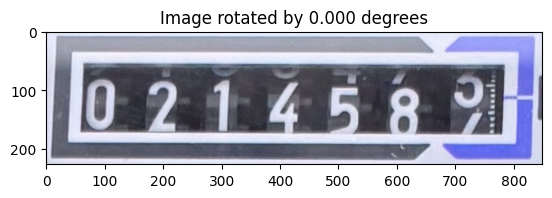

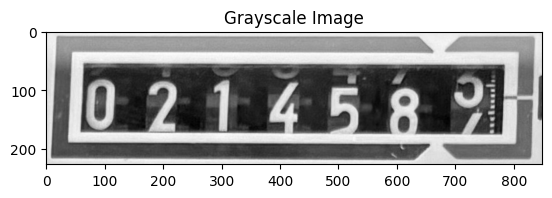

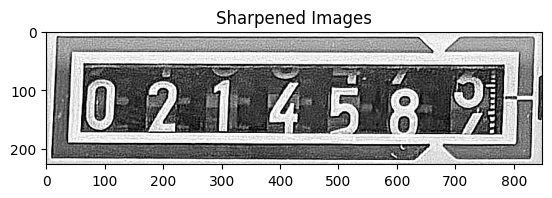

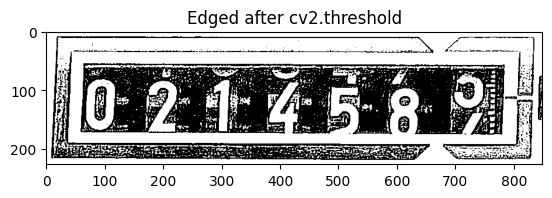

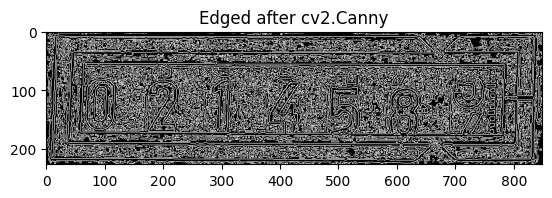

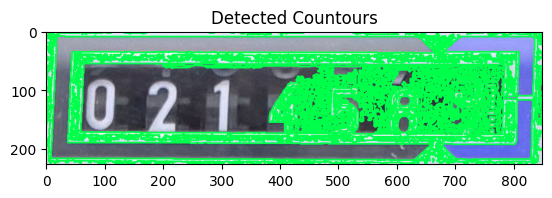

Unrealistic size of box 0: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=630, y=226, h:1, w=2, Area= 0.0
Unrealistic size of box 1: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=432, y=226, h:1, w=4, Area= 0.0
Unrealistic size of box 2: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=398, y=226, h:1, w=5, Area= 0.0
Unrealistic size of box 4: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=735, y=225, h:2, w=4, Area= 0.0
Unrealistic size of box 5: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=489, y=225, h:2, w=5, Area= 2.0
Unrealistic size of box 6: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=445, y=225, h:2, w=8, Area= 2.0
Unrealistic size of box 7: /Users/yonz/W

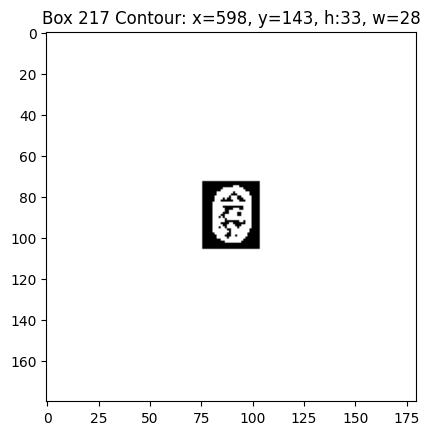

Unrealistic size of box 219: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=709, y=144, h:1, w=2, Area= 0.0
Unrealistic size of box 223: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=704, y=143, h:1, w=2, Area= 0.0
Unrealistic size of box 224: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=509, y=143, h:3, w=6, Area= 3.0
Unrealistic size of box 226: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=738, y=142, h:3, w=4, Area= 0.5
Unrealistic size of box 233: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=563, y=141, h:8, w=9, Area= 1.5
Unrealistic size of box 234: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=388, y=141, h:12, w=13, Area= 15.0
Unrealistic size of box 2

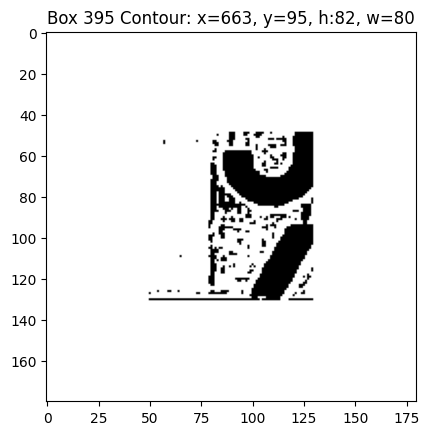

Unrealistic size of box 397: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=759, y=98, h:7, w=10, Area= 37.0
Unrealistic size of box 400: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=438, y=98, h:1, w=3, Area= 0.0
Unrealistic size of box 401: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=770, y=97, h:1, w=2, Area= 0.0
Unrealistic size of box 405: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=446, y=96, h:3, w=4, Area= 0.0
Unrealistic size of box 406: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=619, y=95, h:2, w=5, Area= 0.5
Unrealistic size of box 409: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=724, y=94, h:2, w=3, Area= 0.5
Unrealistic size of box 413: /Us

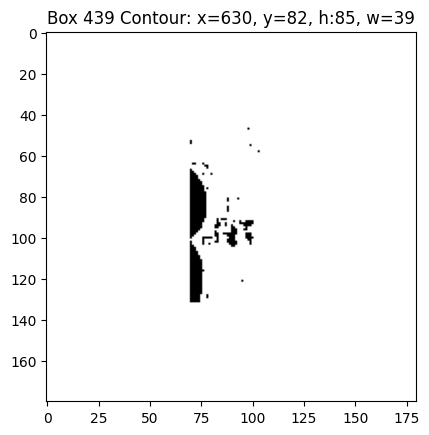

Unrealistic size of box 440: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=492, y=86, h:9, w=17, Area= 40.5
Unrealistic size of box 441: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=754, y=85, h:3, w=6, Area= 1.5
Unrealistic size of box 445: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=720, y=84, h:1, w=3, Area= 0.0
Unrealistic size of box 449: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=761, y=83, h:5, w=9, Area= 29.0
Unrealistic size of box 453: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=724, y=82, h:4, w=7, Area= 1.0
Unrealistic size of box 454: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=720, y=82, h:1, w=3, Area= 0.0
Unrealistic size of box 456: /U

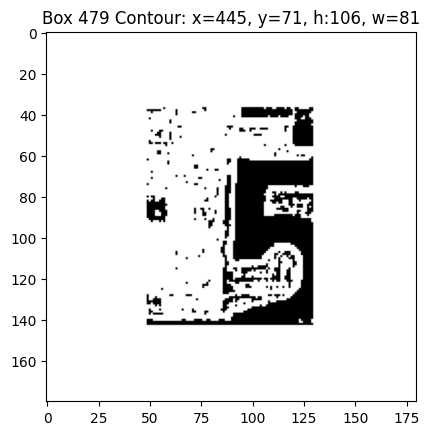

Unrealistic size of box 486: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=676, y=72, h:2, w=4, Area= 0.5
Unrealistic size of box 487: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=627, y=72, h:24, w=32, Area= 169.0
Unrealistic size of box 493: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=568, y=70, h:11, w=21, Area= 26.5
Unrealistic size of box 496: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=582, y=68, h:14, w=18, Area= 38.0
Unrealistic size of box 497: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=583, y=68, h:1, w=5, Area= 0.0
Unrealistic size of box 500: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=756, y=67, h:3, w=4, Area= 0.0
Realistic size of box 50

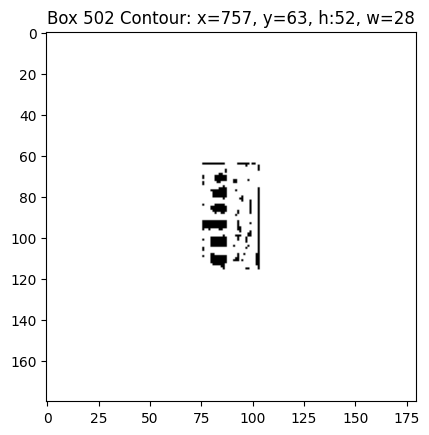

Unrealistic size of box 503: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=728, y=66, h:1, w=2, Area= 0.0
Unrealistic size of box 509: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=773, y=64, h:2, w=5, Area= 0.5
Unrealistic size of box 510: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=479, y=64, h:2, w=4, Area= 0.5
Unrealistic size of box 511: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=781, y=63, h:1, w=2, Area= 0.0
Unrealistic size of box 514: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=780, y=60, h:2, w=3, Area= 0.5
Unrealistic size of box 515: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=747, y=60, h:7, w=34, Area= 31.5
Unrealistic size of box 519: /Us

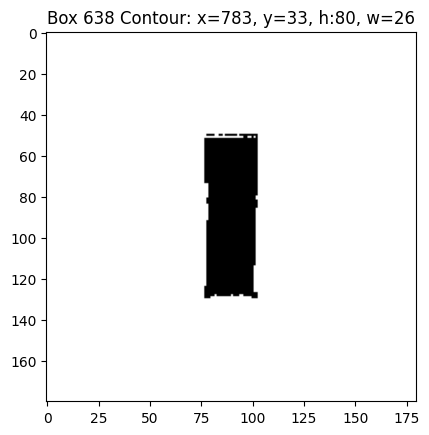

Unrealistic size of box 643: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=0, y=25, h:2, w=8, Area= 1.5
Unrealistic size of box 644: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=0, y=24, h:10, w=11, Area= 3.5
Unrealistic size of box 648: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=682, y=9, h:102, w=155, Area= 5656.0
Unrealistic size of box 650: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=8, y=8, h:213, w=656, Area= 38657.5
Unrealistic size of box 651: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=704, y=6, h:3, w=4, Area= 1.0
Unrealistic size of box 653: /Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg Contour: x=630, y=5, h:7, w=19, Area= 12.5
Unrealistic size of box 6

In [4]:
# Example usage
# image_path = "/Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_6900.jpg"
image_path = "/Users/yonz/Workspace/meterreader2/meterreader_YOLO/counter-1/crops/counter/IMG_69984.jpg"
# image_path = "/home/yonz/workspace/MeterImages/original-3/IMG_6997.jpg"
annotate_meter(image_path)

